In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
# Determine the absolute path to your training data folder.
project_root = os.path.abspath(
    os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')
)

# Insert project_root to sys.path if needed.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Build the path to the data folder (assuming your data folder is directly under the project root)
data_dir = os.path.join(project_root, 'data')
data_small_dir = os.path.join(project_root, 'data_small')
data_small_dir = os.path.join(project_root, 'synth_data')

print("Project root:", project_root)
print("Data directory:", data_dir)

from models import get_model, effnetv2b0_base, effnetv2b3_base,train_model

from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

Project root: /home/phigep/fh/face-mask-detection
Data directory: /home/phigep/fh/face-mask-detection/data


2025-01-26 20:43:59.607980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737920639.621292 1329238 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737920639.625309 1329238 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 20:43:59.640579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1737920642.248847 1329238 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20

In [3]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')
test_small_dir = os.path.join(data_small_dir, 'test')
test_synth_dir = os.path.join(data_small_dir, 'test')

In [4]:
BATCH_SIZE = 32
ORIGINAL_IMAGE_SIZE = (None, None)  # Allow variable sizes
TARGET_IMAGE_SIZE = (224, 224)       # EfficientNetV2's expected input size
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE
temperature = 0.15

In [5]:
from preprocessing import get_augmented_dataset
train_dataset = get_augmented_dataset(train_dir)
test_dataset = get_augmented_dataset(val_dir,batch_size=32,shuffle=False)
test_dataset = get_augmented_dataset(test_dir,batch_size=32,shuffle=False)
test_small_dataset = get_augmented_dataset(test_small_dir,batch_size=1,shuffle=False)
test_synth_dataset = get_augmented_dataset(test_synth_dir,batch_size=1,shuffle=False)



Found 73093 files belonging to 2 classes.
Found 36545 files belonging to 2 classes.
Found 19343 files belonging to 2 classes.
Found 399 files belonging to 2 classes.
Found 399 files belonging to 2 classes.


In [6]:
test_dataset = get_augmented_dataset(test_dir,batch_size=32)

Found 19343 files belonging to 2 classes.


In [3]:
from models import get_fcn_model,get_supervised_contrastive_loss
fcn_modelb0 = get_fcn_model(effnetv2b0_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2)



In [4]:
fcn_modelb0.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,083,280 (23.21 MB)

 Trainable params: 6,022,672 (22.97 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [8]:
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=5e-5)

In [9]:

fcn_modelb0.compile(
    optimizer=optimizer,
    loss=get_supervised_contrastive_loss(0.15)
)


change back to python to train:

In [10]:
import os
from models import get_fcn_model,get_supervised_contrastive_loss
fcn_modelb = fcn_modelb0.fit(train_dataset,epochs=5)

Epoch 1/5


I0000 00:00:1737886027.179727   53661 service.cc:148] XLA service 0x761be0025f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737886027.179762   53661 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-26 11:07:08.620454: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737886031.053411   53661 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-26 11:07:13.524988: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23712', 16 bytes spill stores, 16 bytes spill loads

2025-01-26 11:07:13.654349: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23712_0', 112 

   3/2285 ━━━━━━━━━━━━━━━━━━━━ 1:44 46ms/step - loss: 3.4877   

I0000 00:00:1737886050.291567   53661 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2285/2285 ━━━━━━━━━━━━━━━━━━━━ 172s 55ms/step - loss: 2.8150
Epoch 2/5
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 109s 47ms/step - loss: 2.7352
Epoch 3/5
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 110s 48ms/step - loss: 2.7344
Epoch 4/5
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 109s 48ms/step - loss: 2.7343
Epoch 5/5
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 110s 48ms/step - loss: 2.7344


In [11]:
features=fcn_modelb0.predict(test_dataset)

605/605 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step


In [12]:
from sklearn.manifold import TSNE
import numpy as np

# Initialize t-SNE with desired parameters (e.g., reduce to 2 dimensions)
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

In [13]:
labels_total=[]
for batch_inputs, batch_labels in test_dataset:
    labels_total.append(batch_labels)
labels_ohe = np.concatenate(labels_total, axis=0)
labels_int = np.argmax(labels_ohe, axis=1)

2025-01-26 11:18:00.942817: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


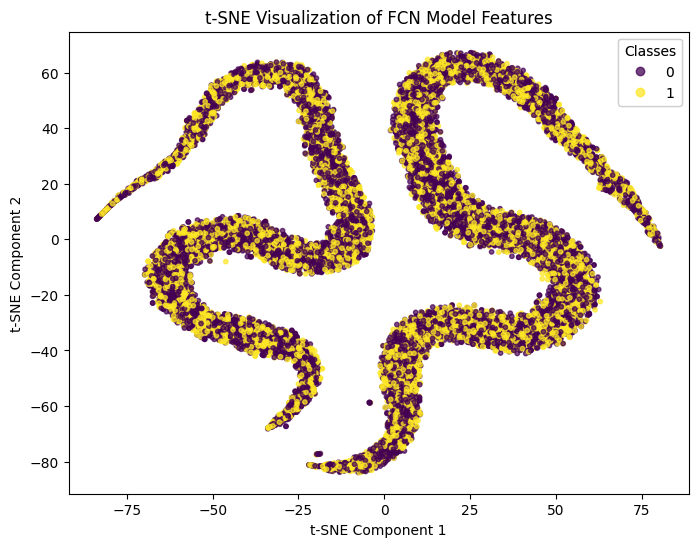

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                      c=labels_int, cmap='viridis', s=10, alpha=0.7)
plt.title("t-SNE Visualization of FCN Model Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Create legend for the classes
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

plt.show()


In [15]:
#create traindataset for catboost
train_data_gbm=[]
train_label_gbm=[]
for batch_inputs, batch_labels in train_dataset:
    train_data_gbm.append(fcn_modelb0.predict(batch_inputs))
    train_label_gbm.append(batch_labels)
#train_labels_xgb_ohe = np.concatenate(train_label_gbm, axis=0)
#train_labels_xgb_int = np.argmax(train_label_gbm, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━

2025-01-26 11:20:56.307879: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
#create traindataset for catboost
test_data_gbm=[]
test_label_gbm=[]
for batch_inputs, batch_labels in test_dataset:
    test_data_gbm.append(fcn_modelb0.predict(batch_inputs))
    test_label_gbm.append(batch_labels)
#train_labels_xgb_ohe = np.concatenate(train_label_gbm, axis=0)
#train_labels_xgb_int = np.argmax(train_label_gbm, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

In [17]:
import numpy as np

def combine_batches(features, labels):
    """
    Combine batched features and labels into a single set for XGBoost.
    
    Parameters
    ----------
    features : np.ndarray
        Feature array of shape (num_batches, batch_size, num_features)
    labels : np.ndarray
        Label array of shape (num_batches, batch_size, num_label_classes)
    
    Returns
    -------
    X : np.ndarray
        Combined feature array of shape (num_batches * batch_size, num_features)
    y : np.ndarray
        Combined label array of shape (num_batches * batch_size, num_label_classes)
    """
    # Check that the number of batches is the same for features and labels
    if features.shape[0] != labels.shape[0]:
        raise ValueError("The number of batches in features and labels must be the same.")
    
    num_features = features.shape[-1]
    X = features.reshape(-1, num_features)
    
    # Reshape labels and convert from one-hot to class indices.
    num_classes = labels.shape[-1]
    labels_reshaped = labels.reshape(-1, num_classes)
    y = np.argmax(labels_reshaped, axis=1)
    
    return X, y



In [18]:
len(test_data_gbm)

605

In [19]:
from sklearn.model_selection import train_test_split
X_train, y_train = combine_batches(np.asarray(train_data_gbm[:3364]),np.asarray(train_label_gbm[:3364]))
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2285,) + inhomogeneous part.

In [116]:
X_test, y_test = combine_batches(np.asarray(test_data_gbm[:592]),np.asarray(test_label_gbm[:592]))

In [105]:
y_train

array([1, 1, 0, ..., 0, 0, 1])

In [123]:
np.shape(X_val)

(21530, 128)

In [125]:
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef, confusion_matrix
from xgboost import XGBClassifier

# Split the data into training and validation sets


# Create an XGBoost classifier
model = XGBClassifier()

# Train the model
model.fit(    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],           # or another metric suited to your problem         # stops training if validation metric doesn't improve for 10 rounds
    verbose=False)
print("Model parameters:")
print(model.get_params())
y_pred = model.predict(X_test)
mcoeff = matthews_corrcoef(y_test, y_pred)
print("Mathew Coeff", mcoeff)
confusion_matrix(y_test,y_pred)


Model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Mathew Coeff 0.9993580364001723


array([[10573,     0],
       [    6,  8365]])

In [126]:

# Predict on the validation set
y_pred = model.predict(X_val)

# Compute the indices of the misclassified samples
misclassified_indices = np.where(y_pred != y_val)[0]

# Retrieve the misclassified samples from the validation set
misclassified_samples = X_val[misclassified_indices]

# Retrieve the true labels and predicted labels for those samples, if desired
misclassified_true_labels = y_val[misclassified_indices]
misclassified_pred_labels = y_pred[misclassified_indices]

print("Misclassified sample indices:", misclassified_indices)
print("Number of misclassified samples:", len(misclassified_indices))
print("True labels for misclassified samples:", misclassified_true_labels)
print("Predicted labels for misclassified samples:", misclassified_pred_labels)

Misclassified sample indices: [ 2785  6405  9966 11958 13236]
Number of misclassified samples: 5
True labels for misclassified samples: [1 0 1 1 1]
Predicted labels for misclassified samples: [0 1 0 0 0]


Feature Importance (by Gain):
{'f1': 0.157099187374115, 'f4': 0.15261632204055786, 'f6': 10.624945640563965, 'f7': 955.6112670898438, 'f12': 2.6663424968719482, 'f14': 0.16889815032482147, 'f30': 42.77894592285156, 'f31': 47.25088119506836, 'f32': 0.7726832628250122, 'f33': 0.4680405855178833, 'f39': 0.13988009095191956, 'f49': 7.015186309814453, 'f52': 114.4468994140625, 'f53': 0.2528040409088135, 'f56': 0.8385384678840637, 'f57': 0.14946657419204712, 'f59': 46.421932220458984, 'f63': 11.48705005645752, 'f66': 0.9632546305656433, 'f73': 0.9007933735847473, 'f76': 0.34379029273986816, 'f77': 0.26749610900878906, 'f81': 14.936688423156738, 'f84': 29.51156234741211, 'f85': 0.7305248975753784, 'f87': 35.98219299316406, 'f92': 0.1438816487789154, 'f94': 0.13941381871700287, 'f100': 294.5081787109375, 'f103': 7780.25146484375, 'f106': 0.13808801770210266, 'f107': 0.13840892910957336, 'f108': 0.30374225974082947, 'f114': 0.2228451818227768, 'f115': 0.5359710454940796, 'f116': 20.084186553955

<Figure size 1000x1000 with 0 Axes>

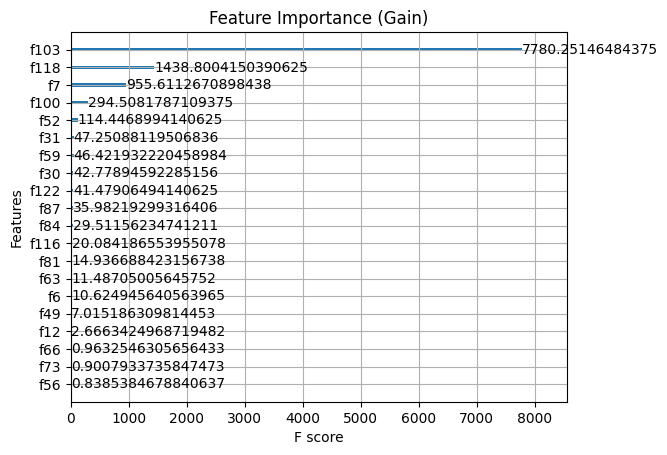

In [127]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
booster = model.get_booster()
importances = booster.get_score(importance_type='gain')
print("Feature Importance (by Gain):")
print(importances)
print("Feature Importances:")
print(importances)

plt.figure(figsize=(10, 10))

plot_importance(model,max_num_features=20, importance_type='gain', title="Feature Importance (Gain)")
plt.show()

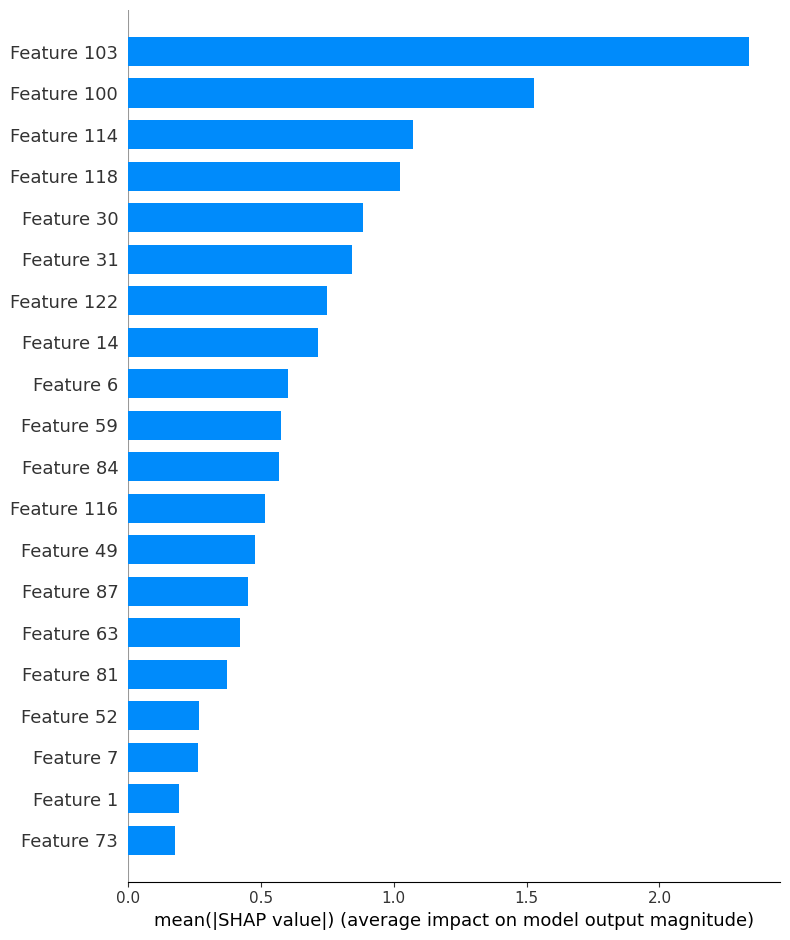

In [108]:
import shap
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for your validation set (or use X_train as needed)
shap_values = explainer.shap_values(X_val)

# For binary classification, shap_values might be a list of two arrays,
# one for each class. Typically, we use the values for the positive class.
if isinstance(shap_values, list):
    # Use SHAP values for class 1, e.g. the "positive" class
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# Generate a bar summary plot of the top 20 most important features
shap.summary_plot(shap_values_to_plot, X_val, plot_type="bar", max_display=20)

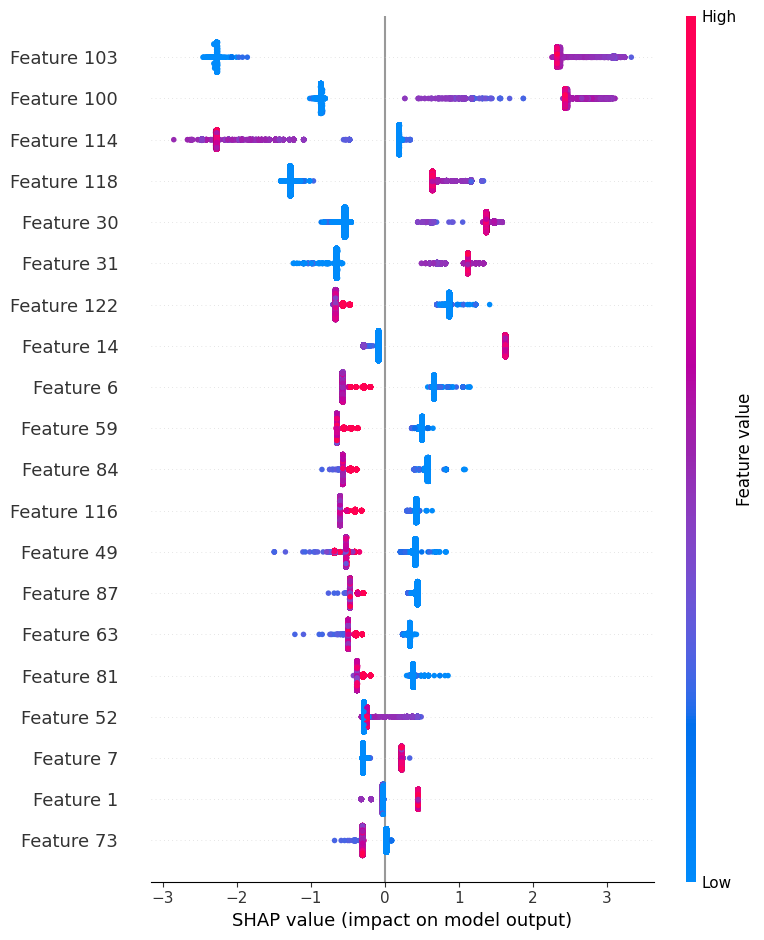

In [128]:
shap.initjs()
shap.summary_plot(shap_values, X_val)

In [113]:
# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate accuracy on the validation set
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9997677659080353


2025-01-18 21:04:10.760938: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


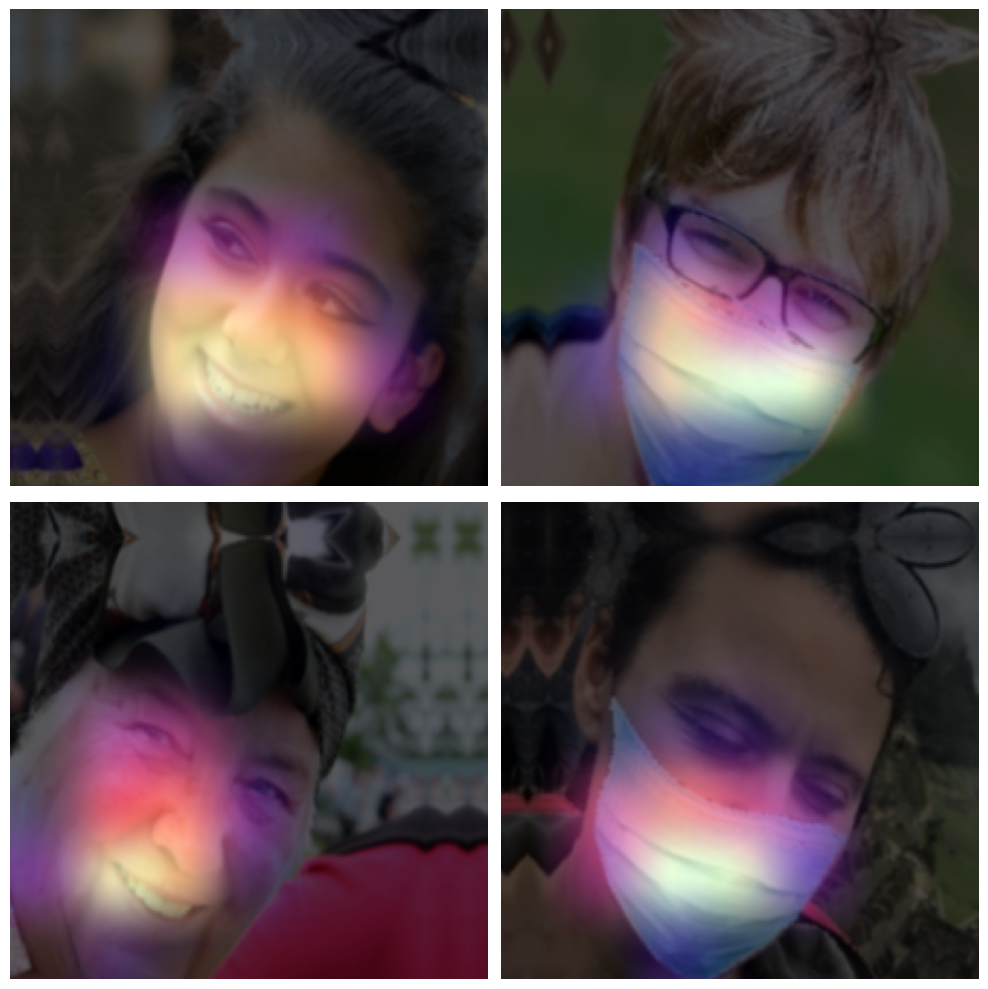

In [157]:
from eval import make_gradcam_heatmap, superimpose_gradcam,plot_images_grid
import matplotlib.pyplot as plt
final_images=[]
for images, labels in test_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=fcn_modelb0,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)